In [9]:
!gdown --id 1WRVJXWU82ZiNZTFLJ3kdh2A9E-gruHmd -O processed.zip

Downloading...
From: https://drive.google.com/uc?id=1WRVJXWU82ZiNZTFLJ3kdh2A9E-gruHmd
To: /content/processed.zip
92.7MB [00:02, 40.8MB/s]


In [10]:
!unzip processed -d processed

Archive:  processed.zip
  inflating: processed/PROCESSED_DATASET.csv  
  inflating: processed/meta_data_with_agg.csv  


In [11]:
config = {
    'NAME': 'v1',    # Title 
    'SEED': 0,       # Any integer
    'INPUT_DAYS': 2, # 1 ~ 7
    'LEARNING_RATE': 0.0005, 
    'DROPOUT': 0.0,
    'EARLYSTOP': 5, # Number of epoches
    'OPTIMIZER': 'adam', # adam, sgd, rmsprop
}

In [12]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import tensorflow as tf
import os, sys
import keras
import random
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv1D, Lambda
from keras.layers import BatchNormalization, Reshape, MaxPooling1D, GlobalAveragePooling1D
from keras import layers
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.optimizers import Adam, SGD, RMSprop
import datetime
import json
from dateutil.parser import parse
from sklearn.model_selection import train_test_split

In [13]:
# 파일로 설정 넣는 용도
if '--config' in sys.argv:
    config_file_idx = sys.argv.index('--config') + 1
    if len(sys.argv) > config_file_idx:
        config_file = sys.argv[config_file_idx]
        if os.path.isfile(config_file):
            with open(config_file) as f:
                config = json.loads(f)
            

In [14]:
opt_map = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop
}

NAME = config['NAME']
SEED = config['SEED']
INPUT_DAYS = config['INPUT_DAYS']
LEARNING_RATE = config['LEARNING_RATE']
DROPOUT = config['DROPOUT']
EARLYSTOP = config['EARLYSTOP']
OPTIMIZER = opt_map[config['OPTIMIZER']]


# Reproduce를 위함
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [15]:
# 저장할 폴더를 생성한다(기본은 NAME과 동일). 이미 있다면 '_숫자'를 붙인다.
DIR = NAME
dir_iter = 1
if os.path.exists(DIR):
    while os.path.exists(DIR):
        DIR = NAME + '_' + str(dir_iter)
        dir_iter += 1
os.mkdir(DIR)
print("Generated a directory:", DIR)


Generated a directory: v1_1


In [16]:
with open(os.path.join(DIR, "model_config.json"), "w") as json_file:
    print("Saving a model config file")
    json.dump(config, json_file)

Saving a model config file


In [17]:
STATIONS = ['400000', '400001', '400009', '400010', '400015', '400017', '400025', '400026', '400027', '400030', '400031', '400037', '400039', '400040', '400041', '400043', '400044', '400045', '400049', '400052', '400053', '400057', '400059', '400060', '400065', '400067', '400071', '400073', '400074', '400075', '400078', '400079', '400082', '400083', '400085', '400088', '400090', '400091', '400093', '400094', '400096', '400097', '400100', '400103', '400107', '400108', '400109', '400110', '400113', '400115', '400116', '400118', '400122', '400124', '400125', '400126', '400127', '400132', '400137', '400138', '400141', '400143', '400145', '400147', '400148', '400149', '400150', '400152', '400153', '400154', '400156', '400158', '400160', '400162', '400164', '400169', '400171', '400172', '400174', '400180', '400181', '400182', '400183', '400184', '400185', '400186', '400189', '400190', '400192', '400193', '400195', '400201', '400202', '400203', '400204', '400206', '400208', '400209', '400211', '400212', '400213', '400214', '400216', '400218', '400221', '400222', '400223', '400224', '400225', '400227', '400228', '400231', '400232', '400235', '400236', '400237', '400238', '400240', '400242', '400248', '400251', '400252', '400253', '400255', '400258', '400260', '400261', '400265', '400268', '400270', '400272', '400274', '400275', '400276', '400280', '400284', '400287', '400289', '400291', '400292', '400295', '400296', '400298', '400300', '400301', '400302', '400303', '400304', '400308', '400309', '400312', '400313', '400314', '400316', '400317', '400318', '400319', '400321', '400322', '400324', '400325', '400329', '400330', '400331', '400333', '400334', '400336', '400337', '400338', '400339', '400340', '400341', '400345', '400349', '400350', '400354', '400359', '400360', '400363', '400369', '400372', '400382', '400388', '400390', '400392', '400393', '400394', '400395', '400400', '400401', '400411', '400414', '400416', '400417', '400418', '400422', '400423', '400425', '400428', '400429', '400430', '400432', '400435', '400436', '400437', '400438', '400440', '400442', '400443', '400444', '400445', '400449', '400450', '400454', '400457', '400460', '400461', '400462', '400463', '400464', '400465', '400470', '400474', '400478', '400479', '400480', '400484', '400485', '400486', '400488', '400490', '400492', '400496', '400497', '400498', '400499', '400501', '400504', '400505', '400508', '400513', '400514', '400516', '400519', '400525', '400528', '400529', '400531', '400534', '400536', '400538', '400539', '400540', '400545', '400546', '400547', '400549', '400551', '400552', '400553', '400554', '400560', '400563', '400565', '400566', '400568', '400570', '400573', '400574', '400576', '400577', '400578', '400579', '400580', '400581', '400582', '400586', '400591', '400598', '400600', '400601', '400602', '400604', '400606', '400607', '400608', '400609', '400611', '400612', '400615', '400617', '400619', '400620', '400622', '400625', '400628', '400630', '400634', '400636', '400637', '400639', '400641', '400643', '400645', '400648', '400649', '400654', '400656', '400657', '400660', '400661', '400662', '400664', '400665', '400666', '400669', '400670', '400673', '400674', '400675', '400676', '400677', '400678', '400679', '400681', '400682', '400683', '400685', '400686', '400687', '400688', '400690', '400691', '400692', '400695', '400696', '400698', '400700', '400703', '400707', '400712', '400713', '400714', '400715', '400716', '400717', '400723', '400726', '400728', '400731', '400733', '400734', '400738', '400739', '400740', '400741', '400742', '400743', '400744', '400747', '400748', '400749', '400750', '400754', '400755', '400756', '400759', '400760', '400763', '400765', '400767', '400769', '400772', '400774', '400778', '400781', '400782', '400783', '400784', '400785', '400788', '400791', '400792', '400793', '400800', '400801', '400805', '400809', '400810', '400815', '400818', '400822', '400823', '400828', '400829', '400835', '400838', '400839', '400844', '400853', '400861', '400863', '400865', '400867', '400868', '400869', '400870', '400873', '400878', '400880', '400883', '400884', '400886', '400891', '400892', '400894', '400895', '400898', '400902', '400904', '400905', '400907', '400911', '400916', '400923', '400928', '400929', '400933', '400934', '400941', '400948', '400949', '400950', '400951', '400952', '400955', '400958', '400961', '400962', '400963', '400964', '400965', '400966', '400970', '400971', '400972', '400973', '400977', '400978', '400983', '400986', '400988', '400993', '400995', '400996', '401003', '401006', '401011', '401012', '401014', '401015', '401016', '401017', '401018', '401038', '401041', '401045', '401052', '401053', '401056', '401058', '401062', '401065', '401066', '401068', '401072', '401073', '401079', '401083', '401084', '401090', '401095', '401097', '401098', '401100', '401102', '401103', '401104', '401106', '401107', '401110', '401111', '401112', '401113', '401114', '401121', '401124', '401126', '401129', '401134', '401137', '401141', '401142', '401143', '401144', '401148', '401151', '401152', '401154', '401155', '401156', '401163', '401167', '401190', '401208', '401211', '401213', '401215', '401216', '401218', '401219', '401221', '401223', '401224', '401226', '401229', '401230', '401234', '401239', '401240', '401242', '401243', '401253', '401260', '401274', '401277', '401280', '401282', '401283', '401285', '401289', '401298', '401301', '401304', '401305', '401314', '401318', '401327', '401328', '401339', '401343', '401344', '401347', '401351', '401356', '401357', '401359', '401362', '401366', '401373', '401390', '401391', '401393', '401394', '401395', '401399', '401400', '401401', '401403', '401405', '401407', '401408', '401411', '401412', '401416', '401421', '401422', '401424', '401426', '401431', '401433', '401434', '401437', '401439', '401440', '401441', '401443', '401444', '401446', '401448', '401450', '401451', '401452', '401454', '401457', '401461', '401462', '401464', '401468', '401469', '401470', '401471', '401472', '401474', '401476', '401478', '401481', '401482', '401483', '401484', '401486', '401488', '401489', '401495', '401496', '401503', '401507', '401509', '401512', '401515', '401517', '401519', '401522', '401523', '401524', '401526', '401529', '401531', '401534', '401538', '401539', '401541', '401542', '401545', '401546', '401548', '401551', '401555', '401557', '401561', '401562', '401564', '401566', '401567', '401568', '401578', '401579', '401580', '401581', '401582', '401583', '401586', '401587', '401588', '401590', '401592', '401593', '401594', '401597', '401598', '401599', '401601', '401602', '401603', '401605', '401606', '401608', '401609', '401610', '401611', '401612', '401613', '401614', '401615', '401616', '401617', '401621', '401624', '401629', '401631', '401634', '401636', '401637', '401639', '401642', '401643', '401649', '401651', '401652', '401653', '401655', '401657', '401658', '401660', '401661', '401663', '401666', '401669', '401670', '401671', '401673', '401674', '401678', '401680', '401683', '401684', '401686', '401688', '401689', '401691', '401692', '401693', '401694', '401695', '401696', '401697', '401698', '401699', '401700', '401701', '401702', '401703', '401704', '401705', '401706', '401708', '401714', '401716', '401718', '401722', '401724', '401728', '401734', '401742', '401748', '401756', '401770', '401774', '401778', '401781', '401782', '401785', '401787', '401788', '401790', '401791', '401793', '401794', '401796', '401797', '401798', '401799', '401800', '401808', '401809', '401810', '401811', '401816', '401817', '401818', '401820', '401825', '401826', '401829', '401830', '401831', '401832', '401833', '401834', '401835', '401837', '401840', '401846', '401851', '401852', '401853', '401856', '401857', '401860', '401868', '401870', '401871', '401872', '401873', '401875', '401877', '401878', '401879', '401881', '401882', '401883', '401888', '401889', '401894', '401898', '401899', '401900', '401901', '401908', '401910', '401911', '401913', '401914', '401917', '401918', '401923', '401924', '401925', '401926', '401927', '401928', '401929', '401934', '401935', '401936', '401937', '401942', '401943', '401950', '401951', '401954', '401955', '401956', '401957', '401958', '401994', '401996', '401997', '401998', '402002', '402003', '402008', '402018', '402027', '402030', '402032', '402042', '402045', '402046', '402048', '402049', '402050', '402051', '402056', '402060', '402061', '402062', '402067', '402068', '402069', '402070', '402071', '402072', '402077', '402085', '402086', '402087', '402088', '402089', '402090']

def load_meta():
    meta = pd.read_csv('processed/meta_data_with_agg.csv')
    meta['ID'] = meta['ID'].apply(str)
    meta.set_index(meta['ID'], inplace=True)
    del meta['ID']
    return meta

class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, meta=load_meta(), validation_rate=0.1, input_days=7, batch_size=32, shuffle=True, stations=None):
        if stations is None:
            self.stations = STATIONS
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.rows_per_day = 24*6
        self.num_meta = 11 # year_sin, year_cos, weekday-one-hot(7), station_mean, station_std
        self.meta = meta
        self.input_days = input_days
        self.input_rows = self.rows_per_day * self.input_days
        self.validation_mode = False
        self.weekdays = []
        self._X = X
        assert len(self._X) % self.rows_per_day == 0
        assert len(self.stations) > batch_size
        self.possible_target_indexes = self.find_possible_target_indexes()
        self.possible_target_indexes = np.array(self.possible_target_indexes)
        self.train_target_indexes, _, self.valid_target_indexes, _ = train_test_split(
            self.possible_target_indexes, self.possible_target_indexes, test_size=validation_rate, random_state=SEED
        )
        self.on_epoch_end()
        
    def set_validation_mode(self, validation):
        self.validation_mode = validation
        
    def find_possible_target_indexes(self):
        target_indexes = []
        for target_index in range(0, len(self._X), self.input_rows):
            start_index = target_index - self.input_rows
            if start_index < 0:
                continue
            else:
                start_dt = self._X.loc[start_index, 'timestamp']
                target_dt = self._X.loc[target_index, 'timestamp']
                diff_days = (target_dt - start_dt).days
                if diff_days == self.input_days:
                    target_indexes.append(target_index)
                    self.weekdays.append(target_dt.weekday())
        return target_indexes
        
    def __len__(self):
        if self.validation_mode:
            return len(self.valid_target_indexes)
        return len(self.train_target_indexes) * (len(STATIONS) // self.batch_size)
    
    def __getitem__(self, index):
        batch_X_raw = np.zeros((self.batch_size, self.input_rows)) # 과거 데이터
        batch_X_meta = np.zeros((self.batch_size, self.num_meta)) # 메타 데이터
        batch_Y = np.zeros((self.batch_size, self.rows_per_day)) # 하루 데이터
        indexes = self.valid_target_indexes if self.validation_mode else self.train_target_indexes
        target_index = indexes[index % len(indexes)]
        target_timestamp = self._X.loc[target_index, 'timestamp']
        target_weekday = target_timestamp.weekday()
        target_stations = np.random.choice(self.stations, self.batch_size, replace=False)
        day = 24*60*60
        year = (365.2425)*day
        
        # station 랜덤 선택
        for i, station in enumerate(target_stations):
            start_index = target_index - self.input_rows
            batch_X_raw[i] = self._X.loc[start_index:target_index - 1, station].values
            batch_X_meta[i] = np.concatenate([
                [np.sin(datetime.datetime.timestamp(target_timestamp) * (2 * np.pi / year) )],
                [np.cos(datetime.datetime.timestamp(target_timestamp) * (2 * np.pi / year) )],
                np.eye(7)[target_weekday],
                [self.meta.loc[station, 'Mean']],
                [self.meta.loc[station, 'Std']],
            ])
            batch_Y[i] = self._X.loc[target_index: target_index + self.rows_per_day - 1, station].values
        return {'raw': batch_X_raw, 'meta': batch_X_meta}, batch_Y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.train_target_indexes)
            
    def get_test_set(self, target_index, target_timestamp, target_station):
        X_raw = np.zeros((1, self.input_rows))
        X_meta = np.zeros((1, self.num_meta))
        target_weekday = target_timestamp.weekday()
        day = 24*60*60
        year=(365.2425)*day
        
        start_index = target_index - self.input_rows
        
        X_raw[0] = self._X.loc[start_index: target_index - 1, target_station].values
        X_meta[0] = np.concatenate([
            [np.sin(datetime.datetime.timestamp(target_timestamp) * (2 * np.pi / year) )],
            [np.cos(datetime.datetime.timestamp(target_timestamp) * (2 * np.pi / year) )],
            np.eye(7)[target_weekday],
            [self.meta.loc[target_station, 'Mean']],
            [self.meta.loc[target_station, 'Std']],
        ])
        return {'raw': X_raw, 'meta': X_meta}

In [18]:
raw_data = pd.read_csv('processed/PROCESSED_DATASET.csv')
def parse_add(s):
    dt = parse(s)
    if dt >= parse('2009-03-17 00:00:00'):
        dt += datetime.timedelta(days=1)
    return dt
raw_data['timestamp'] = raw_data['timestamp'].apply(parse_add)

In [19]:
dg = DataGenerator(X=raw_data, input_days=INPUT_DAYS, shuffle=True)

In [20]:
def build_model(n_meta, n_raw):
    ## Two-branch MLP network using meta data

    ## network for meta data 
    meta_input = Input(shape=(n_meta, ), name='meta')
    meta_net = layers.Dense(32, activation='relu')(meta_input)
    meta_net = Model(inputs = meta_input, outputs=meta_net)
    
    ## network for raw occupancy rate data
    raw_input = Input(shape=(n_raw, ), name='raw')
    raw_net = Reshape((-1, 1))(raw_input)
    raw_net = Conv1D(64, 3, activation='relu')(raw_net)
    raw_net = Conv1D(64, 3, activation='relu')(raw_net)
    raw_net = MaxPooling1D(2)(raw_net)
    raw_net = Conv1D(128, 3, activation='relu')(raw_net)
    raw_net = Conv1D(128, 3, activation='relu')(raw_net)
    raw_net = MaxPooling1D(2)(raw_net)
    raw_net = Flatten()(raw_net)
    raw_net = Model(inputs = raw_input, outputs=raw_net)

    combined = layers.Concatenate()([meta_net.output, raw_net.output])

    final_output = Dense(512, activation='relu')(combined)
    final_output = Dropout(DROPOUT)(final_output)
    final_output = Dense(512, activation='relu')(final_output)
    final_output = Dropout(DROPOUT)(final_output)
    final_output = Dense(144, activation='relu')(final_output)

    model = Model(inputs = [meta_net.input, raw_net.input], outputs=final_output)
    model.compile(loss='mean_squared_error', optimizer = OPTIMIZER(lr = LEARNING_RATE), metrics='mean_squared_error')
    return model

In [22]:
keras.backend.clear_session()
model = build_model(n_meta=11, n_raw=24*6*INPUT_DAYS)

In [23]:
with open(os.path.join(DIR, 'model_summary.txt'),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw (InputLayer)                [(None, 288)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 288, 1)       0           raw[0][0]                        
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 286, 64)      256         reshape[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 284, 64)      12352       conv1d[0][0]                     
_______________________________________________________________________________________

In [24]:
# print(dg[0][0].shape, dg[0][1].shape)
val_min = None
stop_count = 0

while True:
    dg.set_validation_mode(False)
    model.fit_generator(dg)
    dg.set_validation_mode(True)
    val_loss = model.evaluate_generator(dg)[0]
    val_loss = val_loss ** 0.5
    print('RMSE:', val_loss)
    stop_count += 1
    if val_min is None or val_min > val_loss:
        val_min = val_loss
        model_name = os.path.join(DIR, 'model.h5')
        print('New Record! Save model...{}'.format(model_name))
        model.save(model_name)
        stop_count = 0
    if stop_count >= EARLYSTOP:
        break

Instructions for updating:
Please use Model.fit, which supports generators.
4732/4732 [==============================] - 54s 11ms/step - loss: 8.7103e-04 - mean_squared_error: 8.7103e-04
Instructions for updating:
Please use Model.evaluate, which supports generators.
0.025696991147628707
New Record! Save model...v1_1/model.h5
4732/4732 [==============================] - 55s 12ms/step - loss: 6.8551e-04 - mean_squared_error: 6.8551e-04
0.02783280087126355
4732/4732 [==============================] - 54s 11ms/step - loss: 6.6265e-04 - mean_squared_error: 6.6265e-04
0.0237892547139262
New Record! Save model...v1_1/model.h5
4732/4732 [==============================] - 54s 11ms/step - loss: 6.3859e-04 - mean_squared_error: 6.3859e-04
0.023654159843155626
New Record! Save model...v1_1/model.h5
4732/4732 [==============================] - 54s 11ms/step - loss: 6.2277e-04 - mean_squared_error: 6.2277e-04
0.024224674457744656
4732/4732 [==============================] - 53s 11ms/step - loss: 5.

In [26]:
# Load the best model
keras.backend.clear_session()
model = keras.models.load_model(os.path.join(DIR, 'model.h5'))

In [27]:
dg.set_validation_mode(True)
val_loss = model.evaluate_generator(dg)[0]
rmse = val_loss ** 0.5
print('RMSE:', rmse)
with open(os.path.join(DIR, 'rmse.txt'), 'w') as f:
    print('Saving RMSE:', os.path.join(DIR, 'rmse.txt'))
    f.write(str(rmse))

RMSE: 0.029345175544769453


In [28]:
testdates = [(61200, parse('2009-03-12 00:00:00')), (62208, parse('2009-03-20 00:00:00'))]
meta_list = []
raw_list = []
for station in STATIONS:
    for testdate in testdates:
        dataset = dg.get_test_set(*testdate, station)
        meta_list.append(dataset['meta'][0])
        raw_list.append(dataset['raw'][0])

In [29]:
meta_list = np.array(meta_list)

In [30]:
raw_list = np.array(raw_list)

In [31]:
result = model.predict({'meta': meta_list, 'raw': raw_list})

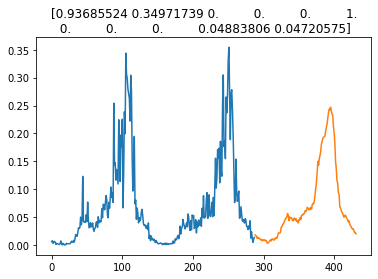

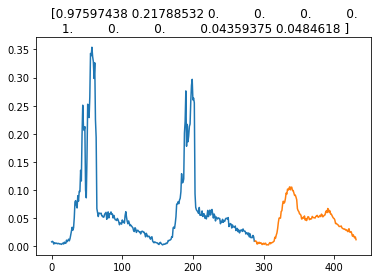

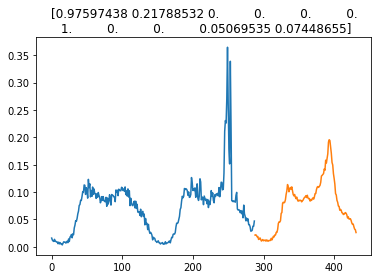

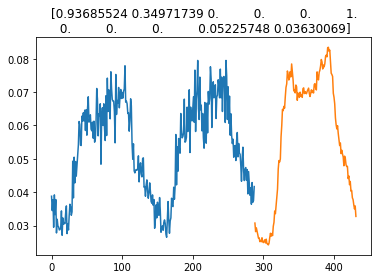

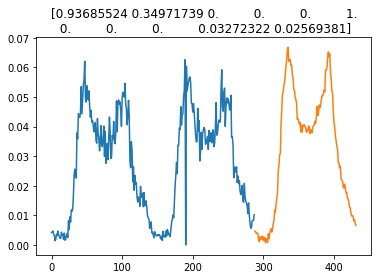

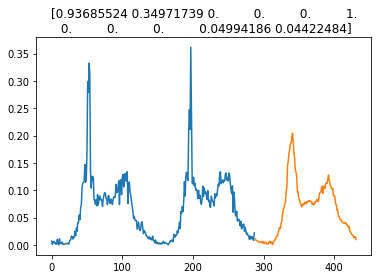

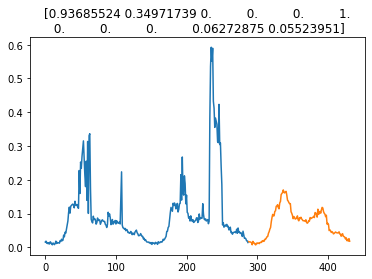

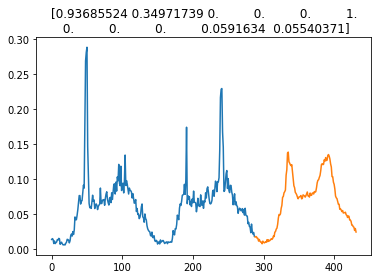

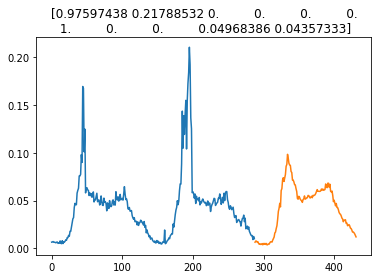

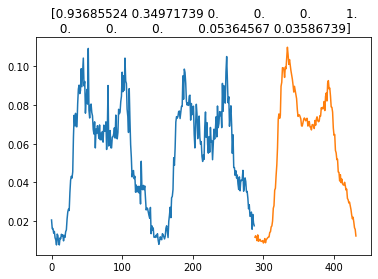

In [32]:
import random
# 결과 몇 개 확인

for i in range(10):
    meta, raw, res = random.choice(list(zip(meta_list, raw_list, result)))
    
    l1 = len(raw)
    l2 = len(res)
    plt.figure()
    plt.plot(range(l1), raw)
    plt.plot(range(l1, l1+l2), res)
    plt.title(str(meta))

In [33]:
result

array([[0.00974118, 0.00977153, 0.01004352, ..., 0.01344799, 0.01346652,
        0.01138428],
       [0.01210785, 0.01171276, 0.01210995, ..., 0.01587599, 0.0167998 ,
        0.01446069],
       [0.0091606 , 0.00913608, 0.00959877, ..., 0.01388272, 0.01371111,
        0.01004819],
       ...,
       [0.01589428, 0.0192561 , 0.01977335, ..., 0.02381359, 0.02047332,
        0.02102686],
       [0.02450751, 0.02416667, 0.0246466 , ..., 0.02293711, 0.02443735,
        0.02226345],
       [0.0236414 , 0.0233899 , 0.02285961, ..., 0.02402843, 0.02546665,
        0.02180822]], dtype=float32)

In [34]:
result1d = result.reshape(-1)

In [35]:
result1d[result1d < 0.0] = 0.0
result1d[result1d > 1.0] = 1.0

In [36]:
result1d

array([0.00974118, 0.00977153, 0.01004352, ..., 0.02402843, 0.02546665,
       0.02180822], dtype=float32)

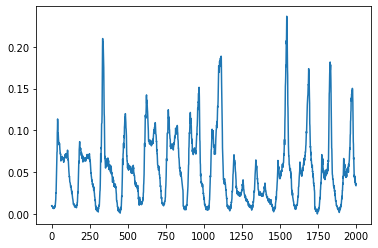

In [37]:
plt.plot(result1d[:2000])
        

In [38]:
res_df = pd.DataFrame({
    'value': result1d
})

In [39]:
res_df['index'] = res_df.index

In [40]:
res_df = res_df[['index', 'value']]

In [41]:
print('Saving submission file:', os.path.join(DIR, 'submission.csv'))
res_df.to_csv(os.path.join(DIR, 'submission.csv'), index=False)